In [3]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from tqdm import tqdm
import matplotlib as mpl
from scipy.stats import binned_statistic_2d
from numba import njit
import h5py as h5

In [4]:
basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/'

In [5]:
name = 'MW4_MHG0.25_GSE6'
name_iso = 'MW4iso_fg0.2_MHG0.25_RC9'
# name120 = 'MW4_MHG0.15_GSE6_kick120'
namecgm = 'MW4_MHG0.25_GSE2_MHG0.5'

In [6]:
# COM = np.load(basepath + 'anlys/COM/COM_'+name+'-lvl4.npy', allow_pickle=True).item()
COM_iso = np.load(basepath + 'anlys/COM/COM_'+name_iso+'-lvl4.npy', allow_pickle=True).item()
# COM120 = np.load(basepath + 'anlys/COM/COM_'+name120+'-lvl4.npy', allow_pickle=True).item()
COMcgm = np.load(basepath + 'anlys/COM/COM_'+namecgm+'-lvl4.npy', allow_pickle=True).item()
COMGFM = np.load(basepath + 'anlys/COM/COM_'+namecgm+'-lvl4-GFM.npy', allow_pickle=True).item()

In [7]:
# sn = {}
sn_iso = {}
# sn120 = {}
sncgm = {}
snGFM = {}
num_list = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200]
for num in tqdm(num_list):
    # try:
    #     sn[num] = arepo.Snapshot(basepath + 'runs/'+name+'/lvl4/output', num, parttype=[0,4], combineFiles=True)
    # except:
    #     pass

    try:
        sn_iso[num] = arepo.Snapshot(basepath + 'runs/'+name_iso+'/lvl4/output', num, parttype=[0,4], combineFiles=True)
    except:
        pass
    
    try:
        sncgm[num] = arepo.Snapshot(basepath + 'runs/'+namecgm+'/lvl4/output', num, parttype=[0,4], combineFiles=True)
    except:
        pass
    
    try:
        snGFM[num] = arepo.Snapshot(basepath + 'runs/'+namecgm+'/lvl4-GFM/output', num, parttype=[0,4], combineFiles=True)
    except:
        pass
    
    # try:
    #     sn120[num] = arepo.Snapshot(basepath + 'runs/'+name120+'/lvl4/output', num, combineFiles=True)
    # except:
    #     pass

100%|██████████| 25/25 [02:26<00:00,  5.87s/it]


In [8]:
@njit
def rodrigues_formula(k, v, theta):
    N = v.shape[0]
    v_rot = np.zeros(np.shape(v))
    
    ctheta = np.cos(theta)
    stheta = np.sin(theta)
    
    for i in range(N):
        v_rot[i] = v[i] * ctheta + np.cross(k, v[i]) * stheta + k * (np.dot(k, v[i])) * (1-ctheta)
    
    return v_rot

In [9]:
def get_rot_pos_vel(pos, vel, snap, COM):
    pos = pos - COM['MW_COM'][snap]
    vel = vel - COM['MW_COMV'][snap]
    
    ang_mom = COM['MW_AngMom'][snap]

    angmom_dir = ang_mom/np.linalg.norm(ang_mom)
    theta = np.arccos(np.dot(angmom_dir, np.array([0, 0, 1])))
    k = np.cross(ang_mom, np.array([0, 0, 1.]))
    k /= np.linalg.norm(k)

    pos_rot = rodrigues_formula(k, pos.astype(np.float64), theta)
    vel_rot = rodrigues_formula(k, vel.astype(np.float64), theta)
    
    return pos_rot, vel_rot

In [10]:
def get_evol(sn, COM, Rmin=4, Rmax=8, zmax=3, center = np.array([200, 200, 200])):

    time = []
    mass = []
    metal_mass = []
    Fe_mass = []
    sfr_dens = []
    
    area = np.pi*(Rmax**2 - Rmin**2)

    for num in sn.keys():
        if num >= len(COM['MW_COM']):
            continue
        
        pos = sn[num].part0.pos.value
        vel = sn[num].part0.vel.value
        pos, vel = get_rot_pos_vel(pos, vel, num, COM)
        
        R = np.linalg.norm(pos[:,:2], axis=1)
        z = pos[:,2]
    
        in_SN = np.logical_and(R < Rmax, R > Rmin)
        in_SN = np.logical_and(in_SN, np.abs(z) < zmax)
        # print(len(np.where(in_disk)[0]))
    
        mass_ = sn[num].part0.mass.value[in_SN]
        mass_ = np.sum(mass_)
    
        metal_mass_ = sn[num].part0.mass.value[in_SN] * sn[num].part0.GFM_Metallicity[in_SN]
        metal_mass_ = np.sum(metal_mass_)
        
        Fe_mass_ = sn[num].part0.mass.value[in_SN] * sn[num].part0.GFM_Metals[in_SN,8]
        Fe_mass_ = np.sum(Fe_mass_)
        
        sfr_ = np.sum(sn[num].part0.sfr[in_SN])
        
        sfr_dens.append(sfr_/area)
    
        mass.append(mass_)
        metal_mass.append(metal_mass_)
        Fe_mass.append(Fe_mass_)
        time.append(sn[num].Time.value)

    out = {}
        
    out['time'] = np.array(time)
    out['mass'] = np.array(mass)
    out['metal_mass'] = np.array(metal_mass)
    out['Fe_mass'] = np.array(Fe_mass)
    out['sfr_dens'] = np.array(sfr_dens)

    return out

In [11]:
Rmin=4
Rmax=12

# evol = get_evol(sn, COM, Rmin=Rmin, Rmax=Rmax)
evol_iso = get_evol(sn_iso, COM_iso, Rmin=Rmin, Rmax=Rmax)
evolcgm = get_evol(sncgm, COMcgm, Rmin=Rmin, Rmax=Rmax)
evolGFM = get_evol(snGFM, COMGFM, Rmin=Rmin, Rmax=Rmax)
# evol120 = get_evol(sn120, COM120)

(0.0, 6.0)

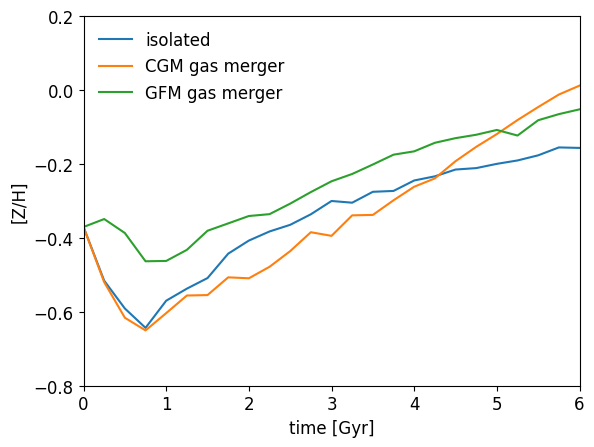

In [12]:
plt.rcParams.update({'font.size': 12})
plt.plot(evol_iso['time'], np.log10((evol_iso['metal_mass']/evol_iso['mass'])/0.0127), label='isolated')
# plt.plot(evol['time'], np.log10((evol['metal_mass']/evol['mass'])/0.0127), label='gas merger')
plt.plot(evolcgm['time'], np.log10((evolcgm['metal_mass']/evolcgm['mass'])/0.0127), label='CGM gas merger')
plt.plot(evolGFM['time'], np.log10((evolGFM['metal_mass']/evolGFM['mass'])/0.0127), label='GFM gas merger')
# plt.plot(evol120['time'], np.log10((evol120['metal_mass']/evol120['mass'])/0.0127))

plt.xlabel('time [Gyr]')
plt.ylabel('[Z/H]')

plt.legend(frameon=False)

plt.ylim(-0.8, 0.2)
plt.axhline(-0.9, c='k', ls='dashed')
plt.xlim(0, 6)

In [17]:
snGFM[0].GFM_Metallicity

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

## gas surface density

In [35]:
def get_gas_surf_dens(sn, COM):
    
    out = {}
    out['time'] = []
    out['Rlist'] = {}
    out['surf_dens'] = {}
    
    for num in sn.keys():
        if num >= len(COM['MW_COM']):
            continue
        
        out['time'].append(sn[num].Time.value)
        
        pos = sn[num].part0.pos.value
        vel = sn[num].part0.vel.value
        mass = sn[num].part0.mass.value
        pos, vel = get_rot_pos_vel(pos, vel, num, COM)
        
        R = np.linalg.norm(pos[:,:2], axis=1)
        z = pos[:,2]

        this_Rlist = []
        this_surf_dens = []
        Rmin = 0.0
        dR = 1.0
        while Rmin < 20.0:
            key = np.logical_and(R >= Rmin, R < Rmin + dR)
            area = np.pi * ((Rmin+dR)**2 - Rmin**2)
            Menc = np.sum(mass[key])
            
            this_Rlist.append(np.mean(R[key]))
            this_surf_dens.append(Menc/area)
            
            Rmin += dR
        
        out['Rlist'][num] = np.array(this_Rlist)
        out['surf_dens'][num] = np.array(this_surf_dens)

    out['time'] = np.array(out['time'])
    
    return out

In [36]:
out_surf_iso = get_gas_surf_dens(sn_iso, COM_iso)
out_surfcgm = get_gas_surf_dens(sncgm, COMcgm)

In [37]:
out_surf_iso.keys()

dict_keys(['time', 'Rlist', 'surf_dens'])

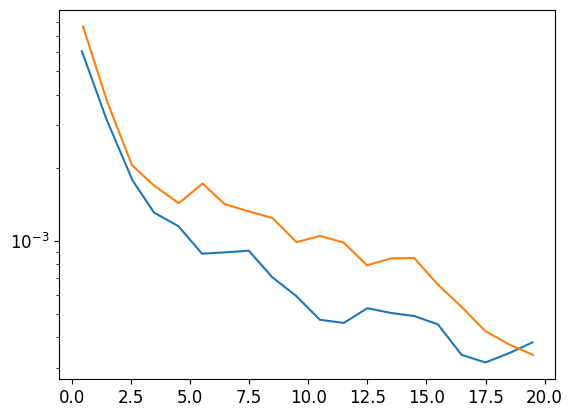

In [43]:
# plt.plot(out_surf_iso['Rlist'][0], out_surf_iso['surf_dens'][0])
# plt.plot(out_surf_iso['Rlist'][200], out_surf_iso['surf_dens'][200])
plt.plot(out_surf_iso['Rlist'][800], out_surf_iso['surf_dens'][800])
plt.plot(out_surfcgm['Rlist'][800], out_surfcgm['surf_dens'][800])

plt.yscale('log')

## sfr

In [45]:
sfh_file = np.genfromtxt(basepath+'runs/GSEiso_fg0.5_Z-1.2/lvl4/output/sfr.txt')
sfh_file_Z0 = np.genfromtxt(basepath+'runs/GSEiso_fg0.5_Z0/lvl4/output/sfr.txt')

In [46]:
sfr = np.genfromtxt(basepath + 'runs/'+name+'/lvl4/output/sfr.txt')
sfr_iso = np.genfromtxt(basepath + 'runs/'+name_iso+'/lvl4/output/sfr.txt')
# sfr120 = np.genfromtxt(basepath + 'runs/'+name120+'/lvl4/output/sfr.txt')
sfrcgm = np.genfromtxt(basepath + 'runs/'+namecgm+'/lvl4/output/sfr.txt')

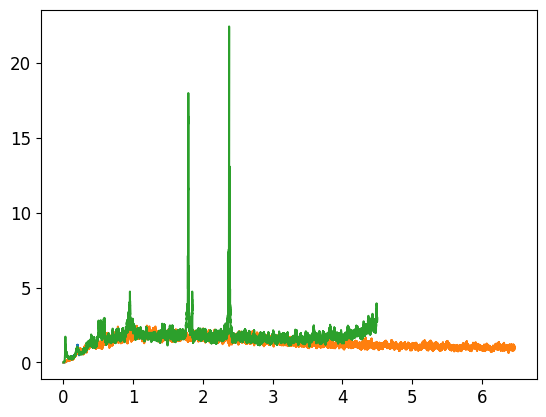

In [47]:
plt.plot(sfr[:,0], sfr[:,2])
plt.plot(sfr_iso[:,0], sfr_iso[:,2])
plt.plot(sfrcgm[:,0], sfrcgm[:,2])

### star particles composition

In [173]:
def get_ZH_dist(sn, num, COM, Rmin=4, Rmax=8, zmax=3):
    num = 600
    pos = sn[num].part4.pos.value
    vel = sn[num].part4.vel.value
    print(np.median(pos, axis=0))
    print(COM['MW_COM'][num])
    pos, vel = get_rot_pos_vel(pos, vel, num, COM)
    
    GFM_SOLAR_ABUNDANCE_IRON   =   0.0013
    
    Rmin = 4
    Rmax = 8
    zmax = 3

    R = np.linalg.norm(pos[:,:2], axis=1)
    inSN = np.logical_and(R > Rmin, R< Rmax)
    print(len(np.where(inSN)[0]))
    inSN = np.logical_and(inSN, np.abs(pos[:,2]) < zmax)
    print(len(np.where(inSN)[0]))
    

    ZH = np.log10(sn[num].part4.GFM_Metallicity/0.0127)
    FeH = np.log10(sn[num].part4.GFM_Metals[:,8]/GFM_SOLAR_ABUNDANCE_IRON)

    return ZH[inSN], FeH[inSN]

[199.57045056 200.14123213 200.0267244 ]
[199.54318869 200.12782722 200.03270232]
5118
5118
[305.43825604 333.09490247 264.33114884]
[305.41982884 333.11618351 264.33793958]
5474
5471


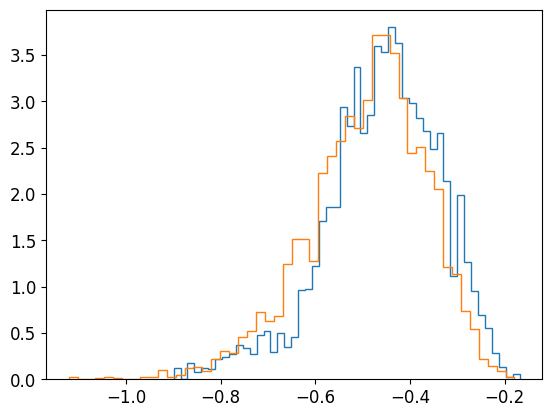

In [175]:
num = 600
ZHiso, FeHiso = get_ZH_dist(sn_iso, num, COM_iso)
ZHcgm, FeHcgm = get_ZH_dist(sncgm, num, COMcgm)

# plt.hist(ZHiso, bins=50, histtype='step', density=True);
# plt.hist(ZHcgm, bins=50, histtype='step', density=True);

plt.hist(FeHiso, bins=50, histtype='step', density=True);
plt.hist(FeHcgm, bins=50, histtype='step', density=True);

In [ ]:
# 

## composition of SN

In [62]:
name = 'MW4_MHG0.25_GSE6'
name_iso = 'MW4iso_fg0.2_MHG0.25_RC9'
# name120 = 'MW4_MHG0.15_GSE6_kick120'
namecgm = 'MW4_MHG0.25_GSE2_MHG0.5'

In [105]:
snap = 400
MC = h5.File(basepath + 'anlys/MC/'+name+'-lvl4/MC_Prop_'+str(snap).zfill(3)+'.h5', mode='r')
MC_iso = h5.File(basepath + 'anlys/MC/'+name_iso+'-lvl4/MC_Prop_'+str(snap).zfill(3)+'.h5', mode='r')
MCcgm = h5.File(basepath + 'anlys/MC/'+namecgm+'-lvl4/MC_Prop_'+str(snap).zfill(3)+'.h5', mode='r')

In [122]:
def get_Rlist_mass(MC):
    Rmax = 20
    dR = 1
    Rmin = 0

    pos = MC['PartType5/RotatedCoordinates'][:]
    memb = MC['PartType5/Membership'][:]
    mtrac = MC['Header'].attrs['TracerMass']
    ptype = MC['PartType5/PartType'][:]
    metal = MC['PartType5/GFM_Metallicity'][:]

    R = np.linalg.norm(pos[:,:2], axis=1)

    out = {}
    out['Rlist'] = []
    out['area'] = []
    out['mass0'] = []
    out['mass1'] = []
    out['mass2'] = []
    out['mass3'] = []
    out['metal0'] = []
    out['metal1'] = []
    out['metal2'] = []
    out['metal3'] = []

    while Rmin < Rmax:
        out['Rlist'].append(Rmin + dR/2.)
        
        area = np.pi * ((Rmin+dR)**2 - Rmin**2)
        out['area'].append(area)
    
        inSN = np.logical_and(R >= Rmin, R < Rmin+dR)
        inSN = np.logical_and(inSN, ptype==0)
        
        m0 = mtrac * len(np.where(np.logical_and(inSN, memb==0))[0])
        m1 = mtrac * len(np.where(np.logical_and(inSN, memb==1))[0])
        m2 = mtrac * len(np.where(np.logical_and(inSN, memb==2))[0])
        m3 = mtrac * len(np.where(np.logical_and(inSN, memb==3))[0])
    
        out['mass0'].append(m0)
        out['mass1'].append(m1)
        out['mass2'].append(m2)
        out['mass3'].append(m3)
        
        if m0 > 0:
            out['metal0'].append(m0 * np.mean(metal[np.logical_and(inSN, memb==0)]))
        else:
            out['metal0'].append(0)
        if m1 > 0:
            out['metal1'].append(m1 * np.mean(metal[np.logical_and(inSN, memb==0)]))
        else:
            out['metal1'].append(0)
        if m2 > 0:
            out['metal2'].append(m2 * np.mean(metal[np.logical_and(inSN, memb==0)]))
        else:
            out['metal2'].append(0)
        if m3 > 0:
            out['metal3'].append(m3 * np.mean(metal[np.logical_and(inSN, memb==0)]))
        else:
            out['metal3'].append(0)
        # out['metal1'].append(m1 * np.mean(metal[np.logical_and(inSN, memb==1)]))
        # out['metal2'].append(m2 * np.mean(metal[np.logical_and(inSN, memb==2)]))
        # out['metal3'].append(m3 * np.mean(metal[np.logical_and(inSN, memb==3)]))
    
        Rmin += dR
    
    for k in out.keys():
        out[k] = np.array(out[k])
    
    return out

(0.0, 20.0)

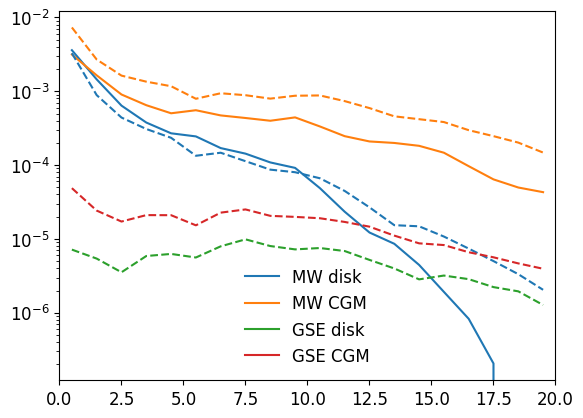

In [123]:
out_iso = get_Rlist_mass(MC_iso)
l0 = plt.plot(out_iso['Rlist'], out_iso['mass0']/out_iso['area'], label='MW disk')
l1 = plt.plot(out_iso['Rlist'], out_iso['mass1']/out_iso['area'], label='MW CGM')
l2 = plt.plot(out_iso['Rlist'], out_iso['mass2']/out_iso['area'], label='GSE disk')
l3 = plt.plot(out_iso['Rlist'], out_iso['mass3']/out_iso['area'], label='GSE CGM')

out = get_Rlist_mass(MCcgm)
l0 = plt.plot(out['Rlist'], out['mass0']/out['area'], c=l0[0].get_color(), ls='dashed')
l1 = plt.plot(out['Rlist'], out['mass1']/out['area'], c=l1[0].get_color(), ls='dashed')
l2 = plt.plot(out['Rlist'], out['mass2']/out['area'], c=l2[0].get_color(), ls='dashed')
l3 = plt.plot(out['Rlist'], out['mass3']/out['area'], c=l3[0].get_color(), ls='dashed')

plt.yscale('log')
plt.legend(frameon=False)
plt.xlim(0, 20)

(0.0, 4.190458605300903)

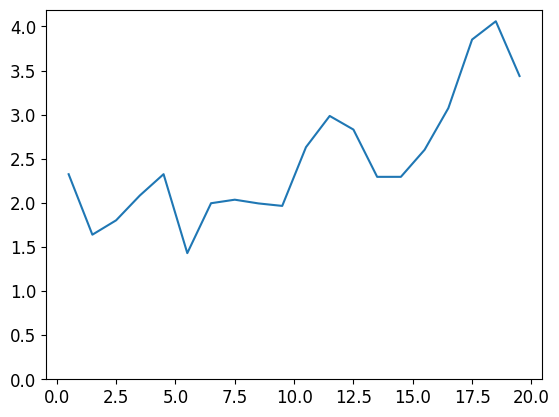

In [124]:
plt.plot(out['Rlist'], out['mass1']/out_iso['mass1'])
plt.ylim(0, None)

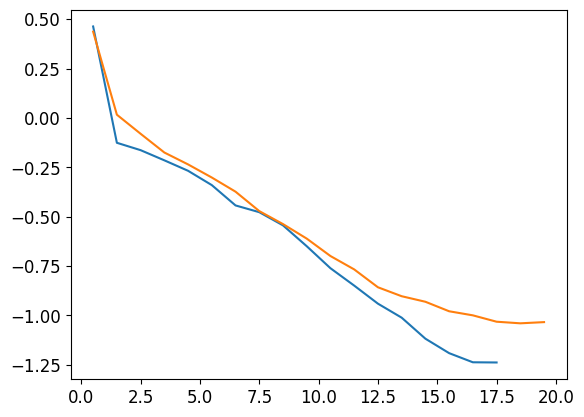

In [125]:
plt.plot(out_iso['Rlist'], np.log10(out_iso['metal1']/out_iso['mass1']/0.0127))
plt.plot(out['Rlist'], np.log10(out['metal1']/out['mass1']/0.0127))

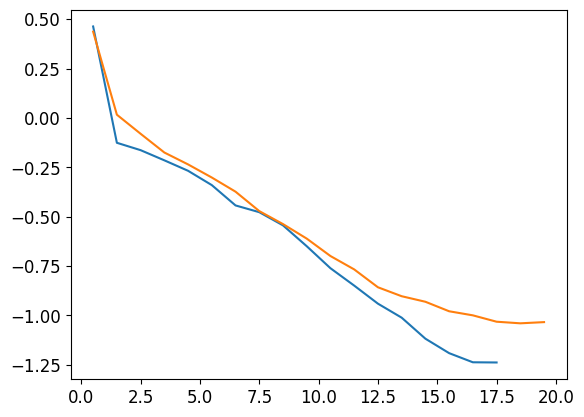

In [127]:
metal_iso = out_iso['metal0'] + out_iso['metal1'] + out_iso['metal2'] + out_iso['metal3']
metal = out['metal0'] + out['metal1'] + out['metal2'] + out['metal3']

mass_iso = out_iso['mass0'] + out_iso['mass1'] + out_iso['mass2'] + out_iso['mass3']
mass = out['mass0'] + out['mass1'] + out['mass2'] + out['mass3']

plt.plot(out_iso['Rlist'], np.log10(metal_iso/mass_iso/0.0127))
plt.plot(out['Rlist'], np.log10(metal/mass/0.0127))

In [121]:
np.nanmean([]) * 0

/tmp/ipykernel_1256081/1338699244.py:1: RuntimeWarning: Mean of empty slice
  np.nanmean([]) * 0


nan

In [66]:
name = 'MW4_MHG0.15_GSE6_kick'
name_iso = 'MW4iso_fg0.2_MHG0.15_RC9'
# name120 = 'MW4_MHG0.15_GSE6_kick120'
# namecgm = 'MW4_MHG0.25_GSE2_MHG0.5'

In [68]:
snap = 400
MC = h5.File(basepath + 'anlys/MC/'+name+'-lvl4/MC_Prop_'+str(snap).zfill(3)+'.h5', mode='r')
MC_iso = h5.File(basepath + 'anlys/MC/'+name_iso+'-lvl4/MC_Prop_'+str(snap).zfill(3)+'.h5', mode='r')
# MCcgm = h5.File(basepath + 'anlys/MC/'+namecgm+'-lvl4/MC_Prop_'+str(snap).zfill(3)+'.h5', mode='r')

(0.0, 20.0)

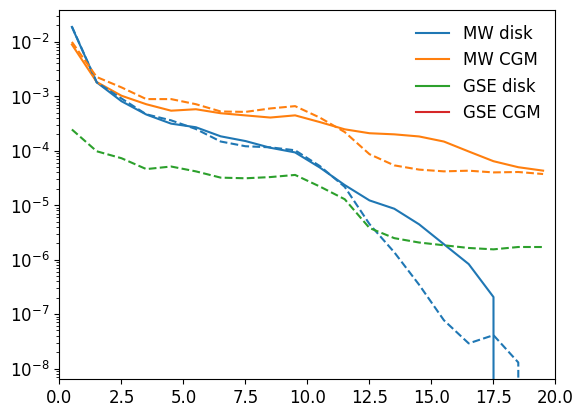

In [70]:
Rlist, mass = get_Rlist_mass(MC_iso)
l0 = plt.plot(Rlist, mass[0], label='MW disk')
l1 = plt.plot(Rlist, mass[1], label='MW CGM')
l2 = plt.plot(Rlist, mass[2], label='GSE disk')
l3 = plt.plot(Rlist, mass[3], label='GSE CGM')

Rlist, mass = get_Rlist_mass(MC)
l0 = plt.plot(Rlist, mass[0], c=l0[0].get_color(), ls='dashed')
l1 = plt.plot(Rlist, mass[1], c=l1[0].get_color(), ls='dashed')
l2 = plt.plot(Rlist, mass[2], c=l2[0].get_color(), ls='dashed')
l3 = plt.plot(Rlist, mass[3], c=l3[0].get_color(), ls='dashed')

plt.yscale('log')
plt.legend(frameon=False)
plt.xlim(0, 20)

## isolated MW CGM profile

In [186]:
def get_n_T(sn):
    UnitLength = sn.parameters.UnitLength_in_cm
    UnitMass = sn.parameters.UnitMass_in_g
    UnitVelocity = sn.parameters.UnitVelocity_in_cm_per_s

    UnitTime = UnitLength / UnitVelocity
    UnitEnergy = UnitMass * UnitVelocity**2

    HYDROGEN_MASSFRAC = 0.76
    GAMMA = 5./3.
    PROTONMASS = 1.67262178e-24
    BOLTZMANN = 1.38065e-16

    InternalEnergy = sn.part0.InternalEnergy.value
    ElectronAbundance = sn.part0.ElectronAbundance
    Density = sn.part0.Density.value
    
    mu = 4 * PROTONMASS / (1 + 3 * HYDROGEN_MASSFRAC + 4 * HYDROGEN_MASSFRAC * ElectronAbundance)
    T = (GAMMA - 1.) * (InternalEnergy / BOLTZMANN) * (UnitEnergy / UnitMass) * mu

    n = Density / mu
    n *= UnitMass/UnitLength**3
    
    return n, T

In [194]:
np.median(sn_iso[0].part0.pos.value, axis=0)

array([199.96865845, 199.97944641, 199.9995575 ])

In [195]:
def get_n_T_mass_r(sn, center=np.array([200, 200, 200])):
    n = {}
    T = {}
    mass = {}
    r = {}

    for i in sn.keys():
        n[i], T[i] = get_n_T(sn[i])

        # center = np.array([sn[i].BoxSize, sn[i].BoxSize, sn[i].BoxSize]) / 2.
        pos = sn[i].part0.pos.value - center
        mass[i] = sn[i].part0.mass.value

        r[i] = np.linalg.norm(pos, axis=1)
    
    return n, T, mass, r



n_iso, T_iso, mass_iso, r_iso = get_n_T_mass_r(sn_iso)


In [196]:
rbins = np.linspace(0, 100, 100)
Tbins = np.linspace(3, 7, 100)

mbin_iso = {}

for i in r_iso.keys():
    mbin_iso[i], x_edge, y_edge, _ = binned_statistic_2d(r_iso[i], np.log10(T_iso[i]), mass_iso[i], 
                                                     statistic='sum', bins=[rbins, Tbins])

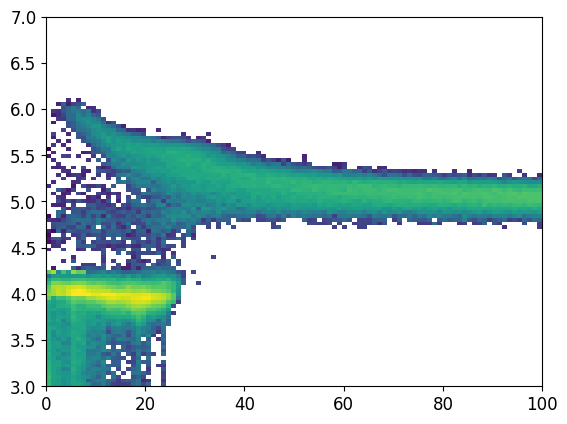

In [197]:
plt.imshow(mbin_iso[400].T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]],
           norm=mpl.colors.LogNorm())
plt.gca().set_aspect('auto')

In [212]:
def print_acc_rate(sn, num, r0=40, dr=2, center=np.array([200, 200, 200])):
    sn_ = sn[num]
    pos = sn_.part0.pos.value - center
    vel = sn_.part0.vel.value
    mass = sn_.part0.mass.value
    sfr = sn_.part0.sfr.value
    
    r = np.linalg.norm(pos, axis=1)
    R = np.linalg.norm(pos[:,:2], axis=1)
    cphi = pos[:,0]/R
    sphi = pos[:,1]/R
    ctheta = pos[:,2]/r
    stheta = np.sqrt(1 - ctheta**2)
    
    vr = stheta * cphi * vel[:,0] + stheta * sphi * vel[:,1] + ctheta * vel[:,2]
    
    key = np.logical_and(r > r0-dr/2., r < r0+dr/2.)
    keyin = np.logical_and(key, vr < 0)
    keyout = np.logical_and(key, vr > 0)
    
    Mdotin = np.sum(mass[keyin] * vr[keyin])/dr
    Mdotout = np.sum(mass[keyout] * vr[keyout])/dr
    
    print(round(Mdotin, 3), round(Mdotout, 3), round(Mdotin+Mdotout, 3))
    print(np.sum(sfr[r < 20]))
    
    rbins = np.linspace(0, 100, 100)
    vrbins = np.linspace(-200, 200, 100)

    mbin, x_edge, y_edge, _ = binned_statistic_2d(r, vr, mass, 
                                                     statistic='sum', bins=[rbins, vrbins])
    
    fig, ax = plt.subplots(1, 1)
    
    ax.imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]],
           norm=mpl.colors.LogNorm())
    ax.set_aspect('auto')
    
    return fig, ax

-0.336 0.0 -0.336
2.3232868


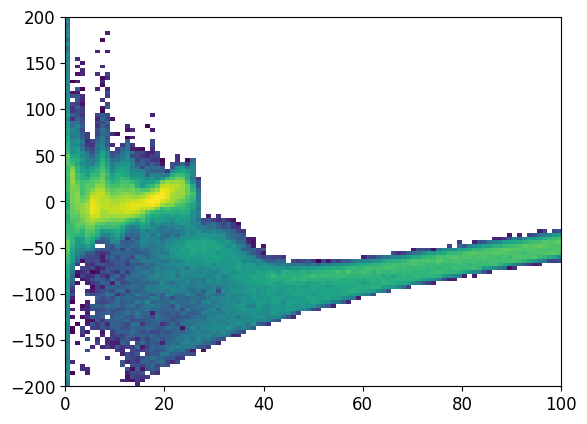

In [213]:
fig, ax = print_acc_rate(sn_iso, 400)

In [ ]:
rbins = np.linspace(0, 100, 100)
Tbins = np.linspace(3, 7, 100)

mbin_iso = {}

for i in r_iso.keys():
    mbin_iso[i], x_edge, y_edge, _ = binned_statistic_2d(r_iso[i], np.log10(T_iso[i]), mass_iso[i], 
                                                     statistic='sum', bins=[rbins, Tbins])